In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn

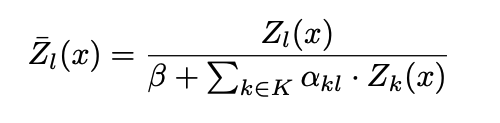

In [3]:
bank_size=512

In [4]:
# 512^2 kernels. scale, two means, two variances, rotation
# = 6 parameters per kernel.
params = torch.rand(bank_size, bank_size, 6, requires_grad=True)

In [5]:
@torch.jit.script
def gaussian_2d(theta, v, w, rho, sigma, A, in_size:int):
    """
    Generate a 2D Gaussian array centered at (mean_x, mean_y) with given standard deviations and rotation angle.

    Args:
    - x (int): Width of the array.
    - y (int): Height of the array.
    - sigma_x (float): Standard deviation along the x-axis.
    - sigma_y (float): Standard deviation along the y-axis.
    - mean_x (float): Mean along the x-axis (default is 0).
    - mean_y (float): Mean along the y-axis (default is 0).
    - theta (float): Rotation angle in radians (default is 0).

    Returns:
    - ndarray: 2D Gaussian array.
    """

    x_indices=torch.linspace(-1,1,in_size)
    xx, yy = torch.meshgrid(x_indices, x_indices)

    # Rotate the coordinate system
    x_rot = xx * torch.cos(theta) - yy * torch.sin(theta)
    y_rot = xx * torch.sin(theta) + yy * torch.cos(theta)

    exponent = -((x_rot - v)**2 / (2 * rho**2) + (y_rot - w)**2 / (2 * sigma**2))
    gaussian = torch.exp(exponent)
    return A * gaussian / torch.sum(gaussian)

In [6]:
@torch.jit.script
def gaussianKernel(theta, v, w, rho, sigma, A, in_size:int):

    Sigma = torch.diag(torch.hstack([rho, sigma]))
    mu = torch.hstack([v,w])

    x=torch.linspace(-1,1,in_size)

    x, y = torch.meshgrid(x, x)

    x_rot = x * torch.cos(theta) + y * torch.sin(theta)
    y_rot = -x * torch.sin(theta) + y * torch.cos(theta)

    pos = torch.zeros(x_rot.shape + (2,))
    pos[:, :, 0] = x_rot
    pos[:, :, 1] = y_rot

    const = A / (2 * torch.pi * rho * sigma)
    
    Sigma_inv = torch.inverse(Sigma)

    delta = torch.subtract(pos,mu)

    fac = torch.einsum('...k,kl,...l->...', delta, Sigma_inv, delta)

    return const * torch.exp(-fac / 2)

In [7]:
from numba import jit

# DOESN'T REALLY WORK...

@jit
def gaussianKernel2(theta, v, w, rho, sigma, A, x=np.linspace(-1,1,51)):

    Sigma = np.diag([rho, sigma])
    mu = np.hstack([v,w])

    # x = np.arange(0, in_size)

    x, y = np.meshgrid(x, x)

    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)

    pos = np.zeros(x_rot.shape + (2,))
    pos[:, :, 0] = x_rot
    pos[:, :, 1] = y_rot

    const = A / (2 * np.pi * rho * sigma)
    
    Sigma_inv = np.inverse(Sigma)

    delta = np.subtract(pos,mu)

    fac = np.einsum('...k,kl,...l->...', delta, Sigma_inv, delta)

    return const * np.exp(-fac / 2)

In [8]:
in_size = 50
kernels = torch.zeros(bank_size,bank_size,in_size,in_size)

for i in range(512):
    for j in range(512):
        kernels[i][j] = gaussian_2d(*params[i][j], in_size)

/var/folders/k1/rw613q855tb9t0l6yc6bw7540000gn/T/ipykernel_57281/2629993067.py:6: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  kernels[i][j] = gaussian_2d(*params[i][j], in_size)


In [8]:
import torch

# Assuming you have your images tensor and weights tensor
images_tensor = torch.randn(32, 512, 25, 25)
weights = torch.randn(512, 512)

# Reshape the images tensor to (4, 1, 512, 25, 25) to match the dimensions for broadcasting
images_tensor_reshaped = images_tensor.unsqueeze(1)

# Reshape the weights tensor to (1, 512, 512, 1, 1) to match the dimensions for broadcasting
weights_reshaped = weights.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

# Perform element-wise multiplication between images_tensor_reshaped and weights_reshaped
weighted_images = images_tensor_reshaped * weights_reshaped

# Compute the sum along the second dimension to get the weighted sum for each image
weighted_sum = torch.sum(weighted_images, dim=2)

In [9]:
denominators = torch.zeros(32,512,25,25)

for batch in images_tensor:
    for row in weights:
        

torch.Size([32, 512, 25, 25])

: 

In [17]:
kernels = torch.zeros(bank_size,bank_size,in_size,in_size)

for i in range(512):
    for j in range(512):
        kernels[i][j] = gaussianKernel(*params[i][j], in_size)

In [ ]:
kernels = torch.zeros(bank_size,bank_size,in_size,in_size)

for i in range(512):
    for j in range(512):
        kernels[i][j] = gaussianKernel2(*params[i][j].detach().numpy())

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function diag at 0x115192200>) found for signature:
 
 >>> diag(list(float32)<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'diag': File: numba/np/arrayobj.py: Line 4581.
    With argument(s): '(list(float32)<iv=None>)':
   No match.

During: resolving callee type: Function(<function diag at 0x115192200>)
During: typing of call at /var/folders/k1/rw613q855tb9t0l6yc6bw7540000gn/T/ipykernel_39626/1207340807.py (6)


File "../../../../var/folders/k1/rw613q855tb9t0l6yc6bw7540000gn/T/ipykernel_39626/1207340807.py", line 6:
<source missing, REPL/exec in use?>


In [9]:
# Example tensors
filters_tensor = torch.randn(512, 512, 50, 50)
images_tensor = torch.randn(4, 512, 50, 50)

In [26]:
results = filters_tensor * images_tensor.unsqueeze(2)

In [27]:
results.shape

torch.Size([4, 512, 512, 50, 50])

In [29]:
btc = 1
i1 = 1
i2 = 4
torch.all(results[btc][i1][i2] == filters_tensor[i1][i2]*images_tensor[btc][i1])

tensor(True)

In [ ]:
# FOLLOWS EXACT FORMULA FROM PAPER

In [22]:
# # Expand the images_tensor along the second dimension to match the shape of the filters_tensor
# expanded_images_tensor = images_tensor
# # expanded_images_tensor = images_tensor.unsqueeze(1).expand(-1, 512, -1, -1)

# # Element-wise multiplication
# result_tensor = filters_tensor * expanded_images_tensor

# # Print the shape of the result tensor
# print("Shape of the result tensor:", result_tensor.shape)

# # this performs the row-wise filter correspondence in the vonenetdn paper
# # ultimately the filter tensor is implicit in the normalisation process
# # the orientation is unsubstantial

# torch.all(result_tensor[0][0][1] == filters_tensor[0][0][1]*images_tensor[0])

In [30]:
# this constitutes the sum term for the denominator
summed = torch.sum(results, dim=1)
beta = 1e-4
summed = summed + beta
summed.shape

torch.Size([4, 512, 50, 50])

In [31]:
norm = images_tensor / summed
# filter-wise division works
torch.all(norm[0] == images_tensor[0] / summed[0])

tensor(True)

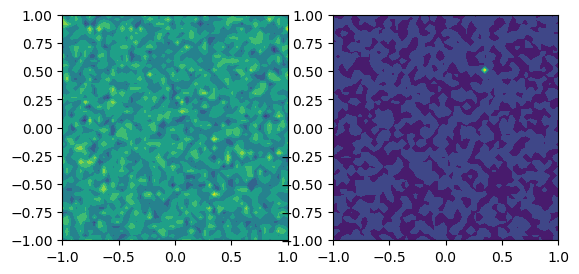

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

x=torch.linspace(-1,1,50)

fig, ax = plt.subplots(1,2)

gk1 = images_tensor[0][1]
gk2 = norm[0][1]
contourf1 = ax[0].contourf(x,x,gk1)
contourf2 = ax[1].contourf(x,x,gk2)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

In [6]:

# UPDATED FORM OF GAUSSIAN KERNEL FUNCTION

@torch.jit.script
def gaussianKernel(theta, v, w, rho, sigma, A, x=torch.linspace(-1,1,51)):

    Sigma = torch.diag(torch.hstack([rho, sigma]))
    mu = torch.hstack([v,w])

    # x = np.arange(0, in_size)

    x, y = torch.meshgrid(x, x)

    x_rot = x * torch.cos(theta) + y * torch.sin(theta)
    y_rot = -x * torch.sin(theta) + y * torch.cos(theta)

    pos = torch.zeros(x_rot.shape + (2,))
    pos[:, :, 0] = x_rot
    pos[:, :, 1] = y_rot

    const = A / (2 * torch.pi * rho * sigma)
    
    Sigma_inv = torch.inverse(Sigma)

    delta = torch.subtract(pos,mu)

    fac = torch.einsum('...k,kl,...l->...', delta, Sigma_inv, delta)

    return const * torch.exp(-fac / 2)

# DIMENSIONS OF OUTPUT FROM VONEBLOCK MUST BE STORED SOMEWHERE!
# MAP FROM PARAMETERS TO FILTER!

class DNBlock(nn.Module):

    # initialise all parameters
    # compute denominator (bias plus params of kernels all trainable?)
    # bank size, image size
    # compute full expression
    # return

    def __init__(self, in_size, bank_size, beta=1e-4):
        super().__init__()

        self.in_size = in_size
        self.bank_size = bank_size
        self.kernel = gaussianKernel

        self.weights = torch.zeros((bank_size, bank_size, in_size, in_size))

        self.beta = beta

        self.initialize()


    def initialize(self):

        # 512^2 kernels. scale, two means, two variances, rotation
        # = 6 parameters per kernel
        params = torch.rand(self.bank_size, self.bank_size, 6)

        self.params = nn.Parameter(params, requires_grad = True)
        # enable autograd to accumulate across params


    def computeCoefficients(self):

        # NEEDS TO HAPPEN ON CPU!!!

        # self.weights = torch.zeros((bank_size, bank_size, in_size, in_size)) (IN INIT)

        x = torch.linspace(-1, 1, self.in_size, device="cpu")

        # I STILL EXPECT THIS TO BE VERY COSTLY.
        for i in range(self.bank_size):
            for j in range(self.bank_size):
                self.weights[i][j] = self.kernel(*params[i][j], in_size=self.in_size)

    def denominator(self,x):

        # neat trickery that enables weights matrix pointwise multiplication
        # in the same fashion that the denominator sum is described
        # in the original paper

        self.computeCoefficients() # ???
        # re-computes the kernels accn. to current state of implicit
        # trainable parameters

        expanded_images_tensor = images_tensor.unsqueeze(2)
        result_tensor = self.weights * expanded_images_tensor
        summed = torch.sum(result_tensor, dim=1)
        summed = summed + self.beta

        return summed

    def forward(self,x):

        den = self.denominator(x)

        return x / den
    


class VOneBlockDN(VOneBlock):

    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):

        super().__init__(sf, theta, sigx, sigy, phase,
                 k_exc, noise_mode, noise_scale, noise_level,
                 simple_channels, complex_channels, ksize, stride, input_size)


        self.dn = DNBlock(in_size=64, bank_size=self.out_channels)
        self.dn.initialize()

    def forward(self, x):
        # Gabor activations [Batch, out_channels, H/stride, W/stride]
        x = self.gabors_f(x)
        # Noise [Batch, out_channels, H/stride, W/stride]
        x = self.noise_f(x)
        # V1 Block output: (Batch, out_channels, H/stride, W/stride)
        x = self.output(x)
        # DN output
        x = self.dn(x)

        return x

array([   0, 1000])

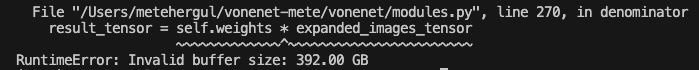

Issue with: Gaussian Kernels computed accurately but also every time a batch is run (img count / 128). Each batch iteration adds on 43s or so...

Tried jit here, doesn't do much.